# Восстановление золота из руды

**Задача:** прототип модели машинного обучения.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. 
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mitosheet as mt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

**Загрузка данных**

In [3]:
df = pd.read_csv('/datasets/gold_recovery_full_new.csv') # полная
train = pd.read_csv('/datasets/gold_recovery_train_new.csv') # обучаяющая
test = pd.read_csv('/datasets/gold_recovery_test_new.csv') # тестовая

**Параметры датасетов**

In [4]:
print(f'Количество образцов обучающей выборки: {len(train)}\n',
    f'Количество образцов тестовой выборки: {len(test)}\n',
    f'Сумма выборок: {len(train) + len(test)}\n',
    f'Количество образцов подготовленной выборки (контрольная сумма):{len(df)}')

Количество образцов обучающей выборки: 14149
 Количество образцов тестовой выборки: 5290
 Сумма выборок: 19439
 Количество образцов подготовленной выборки (контрольная сумма):19439


In [5]:
df.shape

(19439, 87)

In [6]:
df.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

Rougher feed — исходное сырье  
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
Rougher process (англ. «грубый процесс») — флотация  
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота  
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  

Наименование признаков указано по принципу _этап_тип_параметра_название_параметра  

Целевые признаки:
    rougher.output.recovery;
    final.output.recovery.

In [7]:
train.shape, test.shape

((14149, 87), (5290, 53))

Количество столбцов в тесте и трейне отличается. Выясним какие признаки не попали в тест.

In [8]:
lst_3 = [] 

for i in train.columns:  
    if i not in test.columns:  
        lst_3.append(i) 
print(lst_3)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

Отсутствуют признаки из **output** - параметры продуктов, **calculation** - расчётные характеристики.  
Отсутствуют целевые признаки

**Дубликаты**

In [9]:
mydups = df.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)

Количество полных дубликтов в датасете 0


**Период времени**

In [12]:
print('Данные доступны за период от', pd.to_datetime(df['date'].min()), 'до', pd.to_datetime(df['date'].max()))

Данные доступны за период от 2016-01-15 00:00:00 до 2018-08-18 10:59:59


**Проверка эффективности обогащения в обучающей выборке**

In [13]:
def check(data):
    C = data['rougher.output.concentrate_au']
    F = data['rougher.input.feed_au']
    T = data['rougher.output.tail_au']
    
    check = (((C * (F-T))) / (F * (C-T)))*100
    return check

In [14]:
train_recovery = train [['rougher.output.concentrate_au', 
                    'rougher.input.feed_au', 
                    'rougher.output.tail_au',
                    'rougher.output.recovery']].copy()
train_recovery = train_recovery.dropna(axis=0)
train_recovery['test_recovery'] = train_recovery.apply(check, axis=1)
train_recovery.head(7)

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,test_recovery
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308
3,19.320810,6.118189,1.079755,87.226430,87.226430
4,19.216101,5.663707,1.012642,86.688794,86.688794
5,18.950385,5.687168,0.915835,88.156912,88.156912
6,19.319591,6.038436,0.986248,88.168065,88.168065


In [15]:
MAE = mean_absolute_error(train_recovery['rougher.output.recovery'], train_recovery['test_recovery'])
print('МАЕ: {:.17f}'.format(MAE))

МАЕ: 0.00000000000000974


Ошибка минимальна, значения рассчитаны корректно.

### Обучающая выборка

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [17]:
pd.DataFrame(round(train.isna().mean()*100,1)).style.background_gradient('prism')

,0
date,0.000000
final.output.concentrate_ag,0.000000
final.output.concentrate_pb,0.000000
final.output.concentrate_sol,1.500000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,0.700000
final.output.tail_sol,0.000000
final.output.tail_au,0.000000


### Тестовая выборка

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [19]:
pd.DataFrame(round(test.isna().mean()*100,1)).style.background_gradient('prism')

,0
date,0.000000
primary_cleaner.input.sulfate,0.100000
primary_cleaner.input.depressant,0.100000
primary_cleaner.input.feed_size,0.000000
primary_cleaner.input.xanthate,0.100000
primary_cleaner.state.floatbank8_a_air,0.000000
primary_cleaner.state.floatbank8_a_level,0.000000
primary_cleaner.state.floatbank8_b_air,0.000000
primary_cleaner.state.floatbank8_b_level,0.000000
primary_cleaner.state.floatbank8_c_air,0.000000


### Разделение выборок по процессам

In [20]:
X_train = train[test.columns]
rougher_cols = X_train.columns.str.contains('rougher')
X_train_rougher = X_train.loc[:, rougher_cols]
X_test_rougher = test.loc[:, rougher_cols]
y_train_rougher = train[['rougher.output.recovery']]
X_train_rougher.columns

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level'],
      dtype='object')

In [21]:
final_cols = X_train.columns.str.contains('cleaner')
X_train_final = X_train.loc[:, final_cols]
X_test_final = test.loc[:, final_cols]
y_train_final = train[['final.output.recovery']]
X_train_final.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.

In [22]:
X_train_rougher.shape, y_train_rougher.shape, X_test_rougher.shape

((14149, 22), (14149, 1), (5290, 22))

In [23]:
X_train_final.shape, y_train_final.shape, X_test_final.shape

((14149, 30), (14149, 1), (5290, 30))

**Вывод**  
Дано три датасета:
- data
- train
- test 

В тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками. 

Обучающую и тестовуе выборки разделили на две - для этапа флотации и для этапа обработки концентрат.

В тестовой выборке отсутствуют признаки следующие признаки:  

*['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au']*

**output** - параметры продуктов  
**calculation** - расчётные характеристики  
Вероятно, что данные по этим признакам рассчитываются на выходе продукции и доступны после этапа производства

## Анализ

Создадим словарь обозначений элементов.

In [24]:
elements = {'золото': 'au', 'серебро': 'ag', 'свинец': 'pb'}

### Концентрация металлов

Напишем функции для построения график, которые помогут понять концентрацию на различных этапах

In [25]:
def fraction(elem):
    
    cols = ['rougher.input.feed_'+elem, 'rougher.output.concentrate_'+elem, 
            'primary_cleaner.output.concentrate_'+elem, 'final.output.concentrate_'+elem]
    fig_dims = (15, 10)
    fig1, ax1 = plt.subplots(figsize=fig_dims) 
    for col in cols:
                
        sns.kdeplot(train[col], shade=True, alpha=.42, ax=ax1)
        plt.title('Концентрация металла ' + str(elem).title() + ' на различных этапах очистки', fontsize=15)
def boxplot(elem):

    cols = ['rougher.input.feed_'+elem, 'rougher.output.concentrate_'+elem, 
            'primary_cleaner.output.concentrate_'+elem, 'final.output.concentrate_'+elem]
    plt.figure(figsize=(15,10))
    sns.boxplot(data=df[cols], linewidth=0.42, palette="Set2")
    plt.title('Концентрация металла ' + str(elem).title() + ' на различных этапах очистки', fontsize=15)

**Золото**

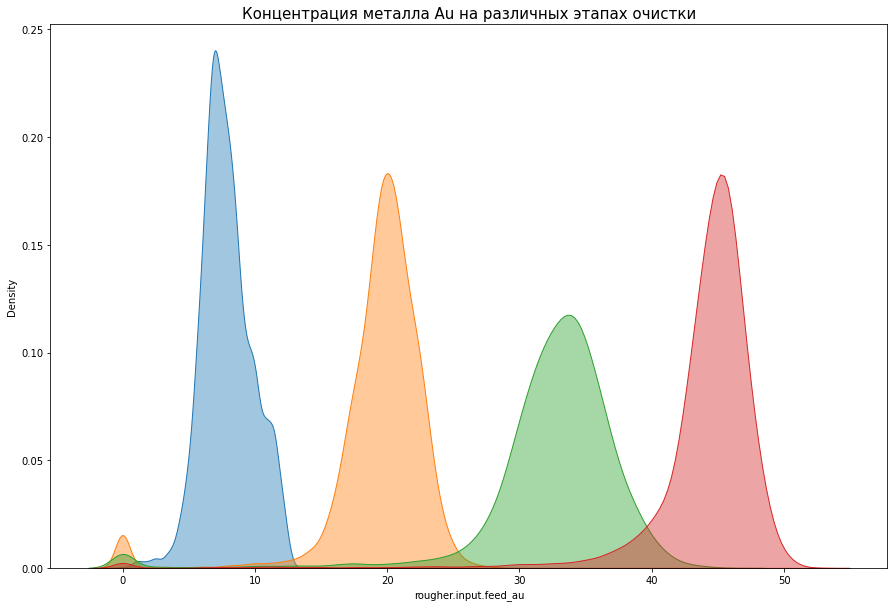

In [26]:
fraction(elements['золото'])

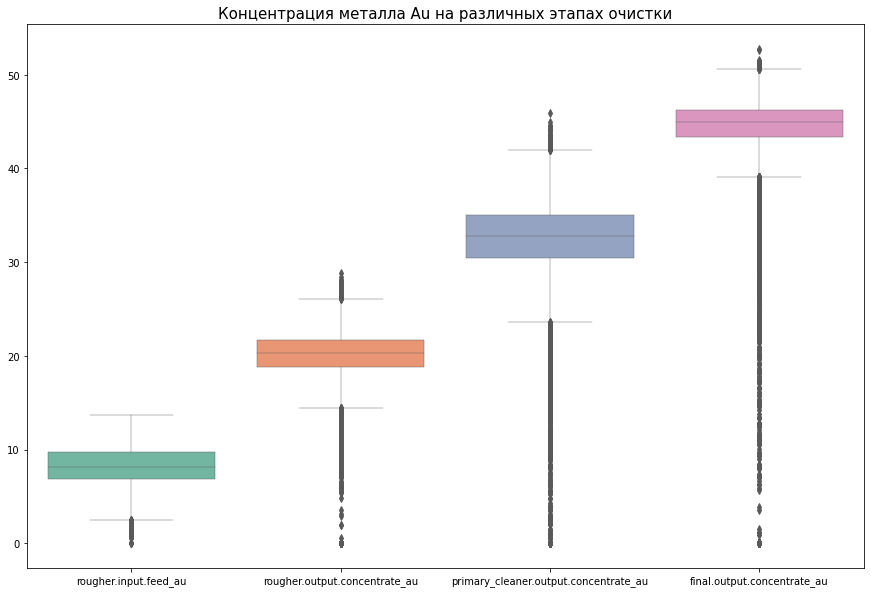

In [27]:
boxplot(elements['золото'])

**Вывод:** концентрация содержания золота повышается поэтапно  и достигиает своих максимальных значений в конце процесса

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Верно!👍:\
</b> Мне интересно было изучить твои графики, практичный и красочный графический анализ. 

**Серебро**

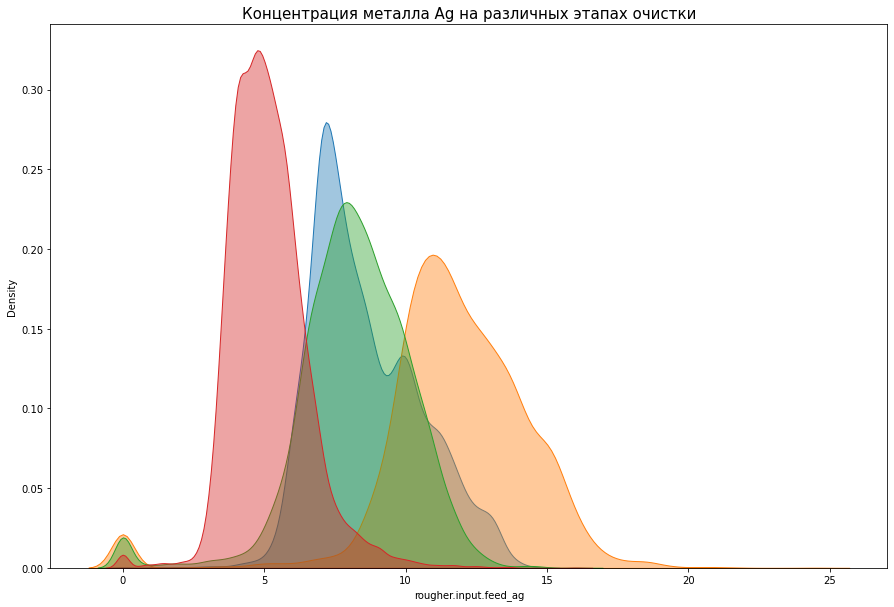

In [28]:
fraction(elements['серебро'])

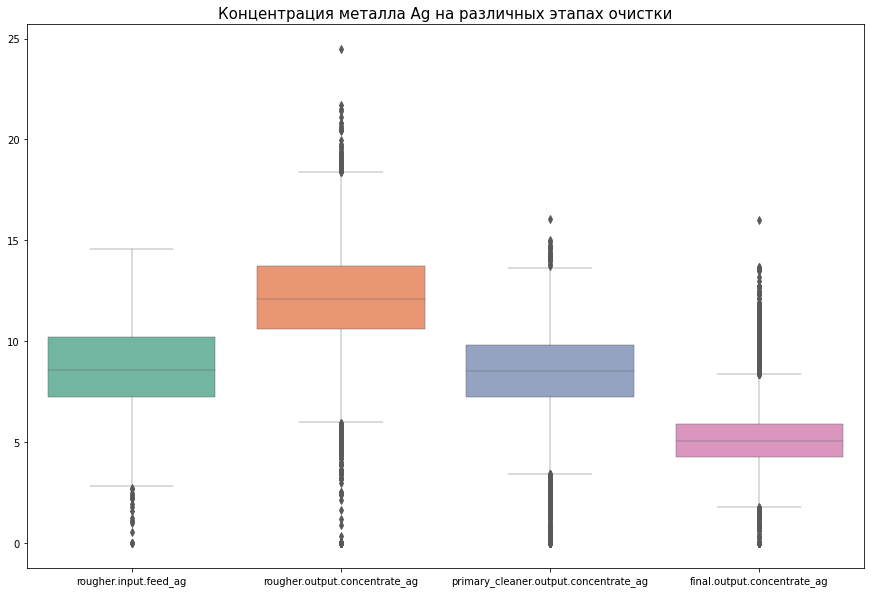

In [29]:
boxplot(elements['серебро'])

**Вывод**: концентрация содержания серебра повышается по завершению этапа флотации но начинает снижаться до минимального значения по сравнению со всеми этапами

**Свинец**

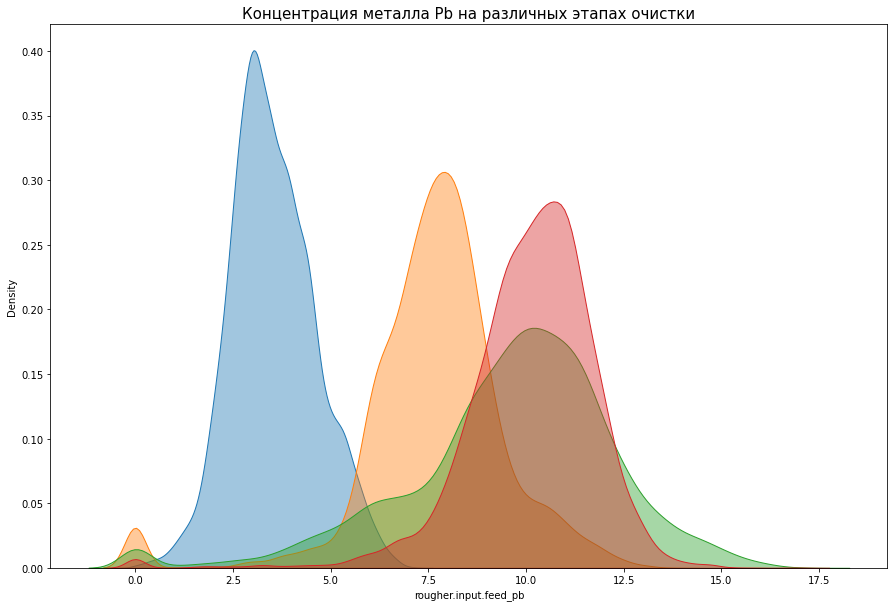

In [30]:
fraction(elements['свинец'])

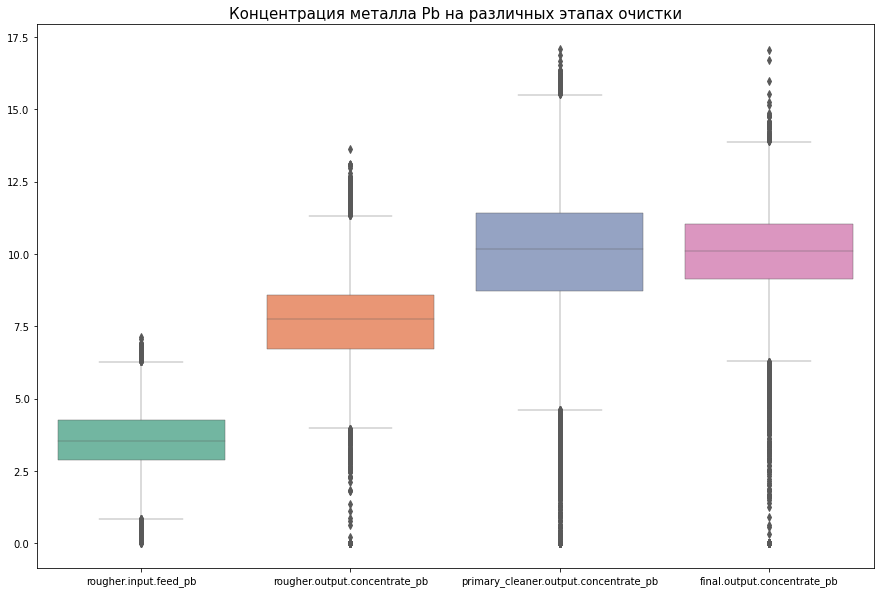

In [31]:
boxplot(elements['свинец'])

**Вывод**: содержание свинца начинает подниматься по завершению эатапа флотации и сохраняется либо незначительно увеличивается на этапах очистки

### Размеры гранул

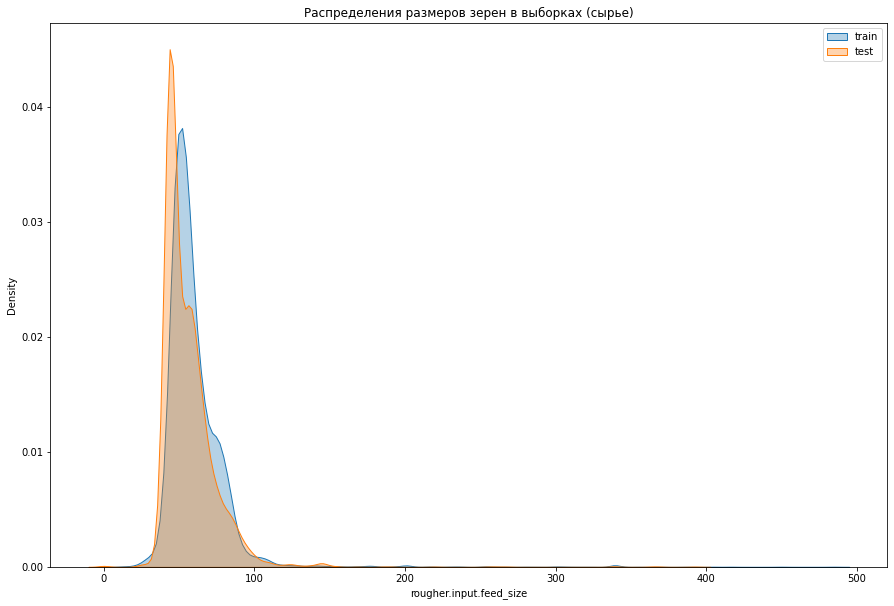

In [32]:
plt.figure(figsize=(15,10))
sns.kdeplot(train['rougher.input.feed_size'].dropna(), label='train', shade=True, alpha=.33)
sns.kdeplot(test['rougher.input.feed_size'].dropna(), label='test', shade=True, alpha=.33)
plt.title('Распределения размеров зерен в выборках (сырье)')
plt.legend()
plt.show()

**Вывод**: размеры находятся на примерно одинаковом уровне.

### Суммарная концентрация

In [33]:
crude = 'rougher.input.feed_'
crude_out = 'rougher.output.concentrate_'
prim_clean = 'primary_cleaner.output.concentrate_'
final = 'final.output.concentrate_'

df['сырье'] = df[[crude+'au', crude+'ag', crude+'pb']].sum(axis=1)
df['черновой концентрат'] = df[[crude_out+'au', crude_out+'ag', crude_out+'pb']].sum(axis=1)
df['концентрат после очистки'] = df[[prim_clean+'au', prim_clean+'ag', prim_clean+'pb']].sum(axis=1)
df['финальный концентрат'] = df[[final+'au', final+'ag', final+'pb']].sum(axis=1)
df[['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']].head()

,сырье,черновой концентрат,концентрат после очистки,финальный концентрат
0,14.871440,38.395653,53.111627,58.137072
1,14.905729,38.945647,53.174338,58.699942
2,14.638299,38.649756,52.927464,58.927421
3,14.199305,38.411473,43.979185,58.714815
4,13.511497,38.867359,52.121146,59.065251


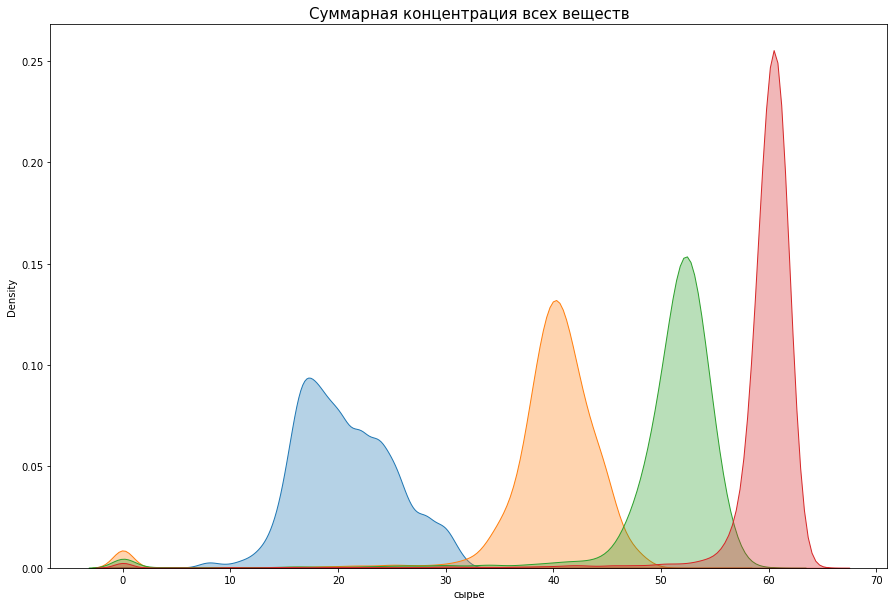

In [34]:
col_1 = ['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']

fig_dims = (15, 10)
fig1, ax1 = plt.subplots(figsize=fig_dims) 
for col in col_1:
                
    sns.kdeplot(df[col], shade=True, alpha=.33, ax=ax1)
    plt.title('Суммарная концентрация всех веществ', fontsize=15)

In [35]:
df[['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']].describe().T

,count,mean,std,min,25%,50%,75%,max
сырье,19439.0,20.640600,4.494362,0.03,17.252879,20.141216,23.797381,33.498784
черновой концентрат,19439.0,39.373032,6.863389,0.00,38.394639,40.312648,42.365102,55.568687
концентрат после очистки,19439.0,50.332682,7.671672,0.00,50.038524,51.905758,53.386172,60.269003
финальный концентрат,19439.0,59.223099,6.097603,0.00,59.298323,60.306921,61.096667,64.968881


**Вывод**  
Проанализировали концентрации металлов на различных стадиях производства:

**золото:**   
повышается по мере очистки и достигиает своих максимальных значений в конце технологического процесса  
**серебро:**   
повышается по завершению этапа флотации и по мере очистики начианет снижаться  
**свинец:**   
содержание свинца начинает подниматься по завершению эатапа флотации и сохраняется либо незначительно увеличивается на этапах очистки


Обнаружены выбросы и нулевые значения концентрация, которые можно принять за аномалии. Избавимся от них.


In [36]:
df.shape

(19439, 91)

In [37]:
crude = 'rougher.input.feed_'
crude_out = 'rougher.output.concentrate_'
prim_clean = 'primary_cleaner.output.concentrate_'
final = 'final.output.concentrate_'

cols_clean = [crude+'au', crude+'ag', crude+'pb', 
             crude_out+'au', crude_out+'ag', crude_out+'pb',
             prim_clean+'au', prim_clean+'ag', prim_clean+'pb',
             final+'au', final+'ag', final+'pb']
for col in cols_clean:
    q25, q75 = df[col].quantile(q=0.25), df[col].quantile(q=0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in df[col] if x < lower or x > upper]
    outliers_removed = [x for x in df[col] if x > lower and x < upper]

print('Найдены выбросы: %d' % len(outliers))

Найдены выбросы: 476


In [38]:
low = .10
high = .95
quant_df = df[cols_clean].quantile([low, high])
df_clean = df[cols_clean].apply(lambda x: x[(x > quant_df.loc[low, x.name]) & 
                                     (x < quant_df.loc[high, x.name])], axis=0)
df_clean.dropna(inplace=True)
df_clean.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb
43,6.845632,6.988699,2.552393,19.161033,12.046412,7.158107,36.080017,8.830847,9.610998,45.358076,5.110753,10.726356
52,7.275418,7.634960,3.084302,18.861112,11.116853,7.855568,34.413681,9.492328,10.462952,43.561270,5.311343,11.675848
53,7.275729,7.383200,2.806724,19.326225,10.795206,7.549066,36.076596,8.777859,10.486529,44.180403,4.936983,11.510876
54,7.265136,7.363098,2.686249,18.084765,11.594501,6.652797,38.268395,8.009489,10.060492,45.490060,4.562255,11.015968
55,7.094447,7.435331,2.565581,19.107428,11.304290,7.130568,37.821583,8.321753,9.737570,46.924587,4.498173,10.570763


In [39]:
df_clean['сырье'] = df_clean[[crude+'au', crude+'ag', crude+'pb']].sum(axis=1)
df_clean['черновой концентрат'] = df_clean[[crude_out+'au', crude_out+'ag', crude_out+'pb']].sum(axis=1)
df_clean['концентрат после очистки'] = df_clean[[prim_clean+'au', prim_clean+'ag', prim_clean+'pb']].sum(axis=1)
df_clean['финальный концентрат'] = df_clean[[final+'au', final+'ag', final+'pb']].sum(axis=1)

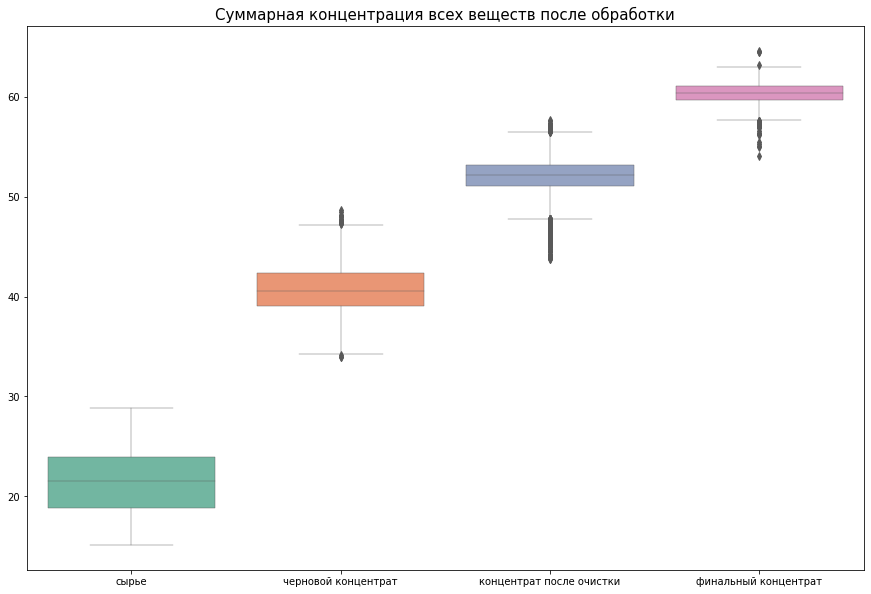

In [40]:
col_1 = ['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']

plt.figure(figsize=(15,10))
sns.boxplot(data=df_clean[col_1], linewidth=0.42, palette="Set2")
plt.title('Суммарная концентрация всех веществ после обработки', fontsize=15)
plt.show()

In [41]:
df_clean.shape

(6751, 16)

Подготовим очищенные данные

**Rougher**

In [42]:
X_train_rougher_clean = X_train_rougher[X_train_rougher.index.isin(df_clean.index)]
X_test_rougher_clean = X_test_rougher[X_test_rougher.index.isin(df_clean.index)]
y_train_rougher_clean = train[['rougher.output.recovery']][train.index.isin(df_clean.index)]
X_train_rougher_clean.shape, X_test_rougher_clean.shape, y_train_rougher_clean.shape

((5343, 22), (1468, 22), (5343, 1))

**Final**

In [43]:
X_train_final_clean = X_train_final[X_train_final.index.isin(df_clean.index)]
X_test_final_clean = X_test_final[X_test_final.index.isin(df_clean.index)]
y_train_final_clean = train[['final.output.recovery']][train.index.isin(df_clean.index)]
X_train_final_clean.shape, X_test_final_clean.shape, y_train_final_clean.shape

((5343, 30), (1468, 30), (5343, 1))

## Модель

### sMAPE

In [44]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    total = 0
    for i in range(len(y_true)):
        total += abs(y_true[i] - y_pred[i]) / ((abs(y_true[i]) + abs(y_pred[i]))/2)
        smape = abs(total*100 / len(y_true))
    return abs(smape)

In [45]:
scorer = make_scorer(smape, greater_is_better=False)

In [46]:
def smape_final(smape_rougher, smape_final):
    smape_final = (0.25 * smape_rougher + 0.75 * smape_final)
    return smape_final

Подготовлены функции расчёта целевой метрики.

### Pipeline

На предыдущем этапе выяснили:
- нулевые значений целевых признаков
- nan пропуски в признаках

Напишем функции, которые необходимо будет применять перед обучением модели для автоматизации процесса


In [47]:
def ffill_y (target):
    target = target.ffill()
    return target

def drop_zeros(X_train, y_train):
    y_train = y_train[(y_train != 0).all(1)]  
    X_train = X_train.loc[y_train.index, :]
    return X_train, y_train

In [48]:
y_train_rougher_1 = ffill_y(y_train_rougher)
y_train_final_1 =  ffill_y(y_train_final)

X_train_rougher_pred, y_train_rougher_pred = drop_zeros(X_train_rougher, y_train_rougher_1)
X_train_final_pred, y_train_final_pred = drop_zeros(X_train_final, y_train_final_1)

**Выборка с выбросами**

In [49]:
num_pipeline_rougher = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

num_pipeline_final = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

In [50]:
X_train_rougher_prep = num_pipeline_rougher.fit_transform(X_train_rougher_pred)
X_train_final_prep = num_pipeline_final.fit_transform(X_train_final_pred)

**Без выбросов**

In [51]:
num_pipeline_rougher_clean = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

num_pipeline_final_clean = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

In [52]:
y_train_rougher_2 = ffill_y(y_train_rougher_clean)
y_train_final_2 =  ffill_y(y_train_final_clean)

X_train_rougher_pred_clean, y_train_rougher_pred_clean = drop_zeros(X_train_rougher_clean, y_train_rougher_2)
X_train_final_pred_clean, y_train_final_pred_clean = drop_zeros(X_train_final_clean, y_train_final_2)

In [53]:
X_train_rougher_prep_clean = num_pipeline_rougher_clean.fit_transform(X_train_rougher_pred_clean)
X_train_final_prep_clean = num_pipeline_final_clean.fit_transform(X_train_final_pred_clean)

### Подбор модели

In [54]:
models = [RandomForestRegressor(random_state=1589), LinearRegression(), Lasso(alpha=0.1)]

In [55]:
%%time
results_cross_val = []
for model in models: 
            
    cross_val_score_rougher = cross_val_score(model, 
                                              X_train_rougher_prep_clean, 
                                              y_train_rougher_pred_clean, 
                                              cv=5, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, 
                                            X_train_final_prep_clean, 
                                            y_train_final_pred_clean, 
                                            cv=5, scoring=scorer).mean()

    results_cross_val.append({'model name': model.__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_final}) 
              
result_clean = pd.DataFrame(results_cross_val)

CPU times: user 1min 12s, sys: 3.49 s, total: 1min 15s
Wall time: 1min 15s


In [56]:
result_clean

,model name,cross_val_score_rougher,cross_val_score_final
0,RandomForestRegressor,-6.234666,-10.689302
1,LinearRegression,-6.404057,-9.951867
2,Lasso,-6.197943,-9.519289


Лучший результат **Lasso**. Попробуем подобрать параметры для улучшения результата.

In [57]:
%%time
param_grid = [{'fit_intercept': [True, False],
               'alpha': [0.1, 0.2, 0,3],
              'normalize': [True, False]}
             ]

lasso_reg = Lasso(alpha=0.1, normalize=True, max_iter=750)

grid_search_clean = GridSearchCV(lasso_reg, param_grid, cv=5,
                           scoring=scorer, return_train_score=True)
grid_search_clean.fit(X_train_rougher_prep_clean, y_train_rougher_pred_clean)

CPU times: user 14.5 s, sys: 26.1 s, total: 40.6 s
Wall time: 40.8 s


GridSearchCV(cv=5, estimator=Lasso(alpha=0.1, max_iter=750, normalize=True),
             param_grid=[{'alpha': [0.1, 0.2, 0, 3],
                          'fit_intercept': [True, False],
                          'normalize': [True, False]}],
             return_train_score=True,
             scoring=make_scorer(smape, greater_is_better=False))

In [58]:
grid_search_clean.best_params_

{'alpha': 0.2, 'fit_intercept': True, 'normalize': False}

**Rougher**

In [59]:
final_model = grid_search_clean.best_estimator_

X_test_rougher_pred_clean = num_pipeline_rougher_clean.transform(X_test_rougher_clean)
y_test_clean = ffill_y(df.loc[X_test_rougher_clean.index, 'rougher.output.recovery'])

final_predictions = final_model.predict(X_test_rougher_pred_clean) 

In [60]:
rougher_clean = smape(final_predictions, y_test_clean)
rougher_clean 

8.146431825047463

**Final**

In [61]:
%%time
param_grid = [{'fit_intercept': [True, False],
               'alpha': [0.1, 0.2, 0,3],
              'normalize': [True, False]},
             ]

lasso_reg_final_clean = Lasso(alpha=0.1, normalize=True, max_iter=750)

grid_search_final_clean = GridSearchCV(lasso_reg_final_clean, param_grid, cv=5,
                           scoring=scorer, return_train_score=True)
grid_search_final_clean.fit(X_train_final_prep_clean, y_train_final_pred_clean)

CPU times: user 18.4 s, sys: 35.9 s, total: 54.3 s
Wall time: 54.3 s


GridSearchCV(cv=5, estimator=Lasso(alpha=0.1, max_iter=750, normalize=True),
             param_grid=[{'alpha': [0.1, 0.2, 0, 3],
                          'fit_intercept': [True, False],
                          'normalize': [True, False]}],
             return_train_score=True,
             scoring=make_scorer(smape, greater_is_better=False))

In [62]:
final_model_fin = grid_search_final_clean.best_estimator_
X_test_final_pred_clean = num_pipeline_final_clean.transform(X_test_final_clean)
y_test_fin_clean = ffill_y(df.loc[X_test_final_clean.index, 'final.output.recovery'])

final_predictions_final = final_model_fin.predict(X_test_final_pred_clean)


In [63]:
final_clean = smape(final_predictions_final, y_test_fin_clean)
final_clean

9.025618084365028

**Константная модель**

In [64]:
predicted_valid_rog = pd.Series(y_train_rougher_pred_clean['rougher.output.recovery'].mean(), index=y_test_clean.index)
rog = smape(y_test_clean, predicted_valid_rog)

predicted_valid_fin = pd.Series(y_train_final_pred_clean['final.output.recovery'].mean(), index=y_test_fin_clean.index)
fin = smape(y_test_fin_clean, predicted_valid_fin)


print(rog)
print(fin)

7.030476031310527
6.381394978071765


**Вывод**

В результате проведенного исследования, выяснили что предоставленный тестовый сет отличается по содержанию от обучающего.  

В ходе исследования выяснили, что в сетах присутствуют аномалии - нулевые значения концентраций веществ, что может являться ошибкой.

Мы обучили модели на двух группах даннах - с выбросами и без выбросов. Лучший результат по метрике sMAPE показала модель Lasso, модель незначительно лучше константной.
